In [ ]:
!pip install qutip 
# Install QuTiP if not already installed

c:\Users\shrey\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


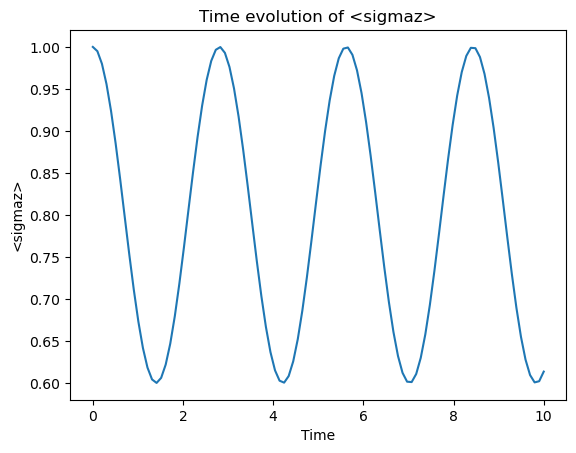

In [1]:
import numpy as np
import qutip as qt

# Define Pauli matrices
sx = qt.sigmax()
sz = qt.sigmaz()

# Define Hamiltonian: H = 0.5 * sx + 1.0 * sz
H = 0.5 * sx + 1.0 * sz

# Initial state: |0>
psi0 = qt.basis(2, 0)

# Time points
tlist = np.linspace(0, 10, 100)

# Solve Schrödinger equation
result = qt.sesolve(H, psi0, tlist, [sz])

# Expectation value of sz
import matplotlib.pyplot as plt
plt.plot(tlist, result.expect[0])
plt.xlabel('Time')
plt.ylabel('<sigmaz>')
plt.title('Time evolution of <sigmaz>')
plt.show()


In [53]:
# pip install qutip
import numpy as np
from qutip import tensor, qeye, sigmax, sigmaz, basis
from qutip import expect

# ---------- helpers ----------
def local_op(op, i, N):
    """Place single-site operator `op` at site i in an N-spin chain."""
    ops = [qeye(2)] * N
    ops[i] = op
    return tensor(ops)

def two_site_op(opA, i, opB, j, N):
    """Place two-site operators opA at i and opB at j in an N-spin chain."""
    if i == j:
        raise ValueError("i and j must be different for a two-site operator.")
    ops = [qeye(2)] * N
    ops[i] = opA
    ops[j] = opB
    return tensor(ops)

def long_range_norm(N, alpha):
    """
    Normalization commonly used for Kac-like rescaling in long-range models.
    Returns 𝒩_N(α) = (1/(N-1)) * sum_{r=1}^{N-1} 1/r^α
    so you can scale J_long -> J_long / 𝒩_N(α).
    """
    r = np.arange(1, N)
    return np.sum(1.0 / (r ** alpha)) / (N - 1)

# ---------- Hamiltonian builder ----------
def build_hamiltonian(N, B=0.0, Jz=0.0, Jlong=0.0, alpha=0.0,
                      periodic=False, kac_rescale=False):
    """
    Build H = B Σ_i σ^z_i + Jz Σ_<i,i+1> σ^z_i σ^z_{i+1}
            + Jlong Σ_{i<j} (1/|i-j|^α) σ^x_i σ^x_j

    Args:
        N (int): number of spins (spin-1/2).
        B (float): field strength on σ^z.
        Jz (float): NN coupling strength for σ^z σ^z.
        Jlong (float): long-range σ^x σ^x base coupling.
        alpha (float): decay exponent for long-range term (α=0 → infinite-range).
        periodic (bool): if True, include bond (N-1, 0) for the NN Jz term.
        kac_rescale (bool): if True, rescale Jlong by 𝒩_N(α) defined above.

    Returns:
        Qobj: the Hamiltonian.
    """
    H = 0

    # Field term: B * sum_i σ^z_i
    if abs(B) > 0:
        for i in range(N):
            H += B * local_op(sigmaz(), i, N)

    # NN Ising term: Jz * sum_i σ^z_i σ^z_{i+1}
    if abs(Jz) > 0:
        for i in range(N - 1):   # always add all N-1 bonds for OBC
            H += Jz * two_site_op(sigmaz(), i, sigmaz(), i + 1, N)
        if periodic:
            H += Jz * two_site_op(sigmaz(), N - 1, sigmaz(), 0, N)


    # Long-range σ^x σ^x with power-law decay
    if abs(Jlong) > 0:
        scale = 1.0
        if kac_rescale:
            # Kac-like normalization (divide by 𝒩_N(α))
            norm = long_range_norm(N, alpha)
            # Avoid divide-by-zero if alpha → ∞ (no LR anyway), just guard:
            if norm > 0:
                scale = 1.0 / norm

        for i in range(N - 1):
            for j in range(i + 1, N):
                r = min(j - i, N - (j - i)) if periodic else (j - i)
                coeff = (Jlong * scale) / (r ** alpha if alpha != 0 else 1.0)
                H += coeff * two_site_op(sigmax(), i, sigmax(), j, N) #AFM sign convention

    return H

# ---------- example usage ----------
if __name__ == "__main__":
    N = 6
    B = 0
    Jz = 0
    Jlong = -1
    alpha = 100.0  # Large alpha → effectively NN

    H = build_hamiltonian(
        N, B=B, Jz=Jz, Jlong=Jlong, alpha=alpha,
        periodic=False, kac_rescale=False
    )

    evals = H.eigenenergies(eigvals=3)
    print("Ground energy:", np.round(evals[0], 5))
    print("First excited energy:", np.round(evals[1], 5))
    print("Second excited energy:", np.round(evals[2], 5))





Ground energy: -5.0
First excited energy: -5.0
Second excited energy: -3.0


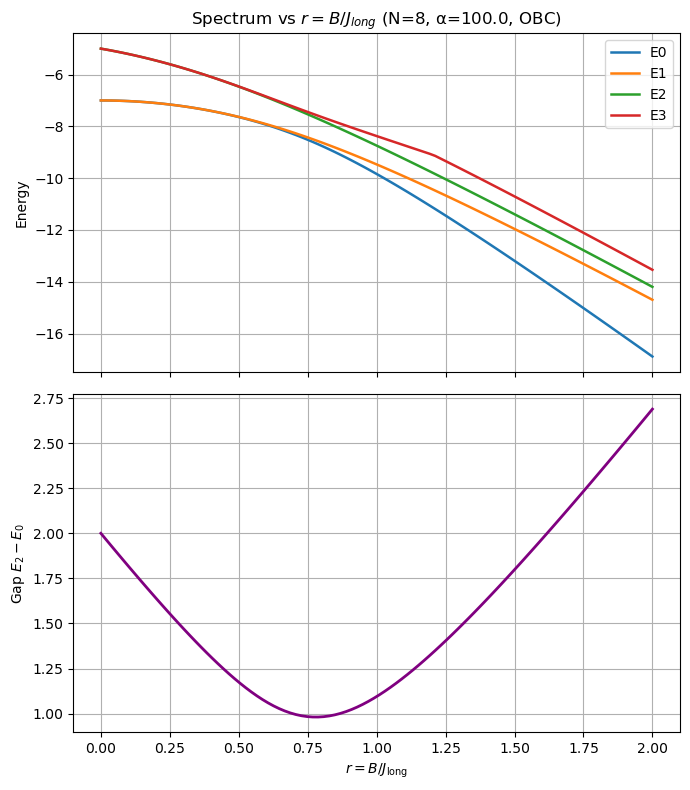

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- parameters ----------
N = 8
Jz = 0
Jlong = -1         # FM convention
alpha = 100.0      # effectively NN
periodic = False

r_vals = np.linspace(0, 2.0, 100)      # r = B/Jlong
spectra = []
gaps = []

for r in r_vals:
    B = r * Jlong
    H = build_hamiltonian(N, B=B, Jz=Jz, Jlong=Jlong,
                          alpha=alpha, periodic=periodic,
                          kac_rescale=False)

    evals = H.eigenenergies(eigvals=4)  # lowest 4 eigenvalues
    spectra.append(evals)
    gaps.append(evals[2] - evals[0])    # gap = E2 - E0

spectra = np.array(spectra)

# ---------- plotting ----------
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Spectrum plot (E0..E3)
for i in range(4):
    axes[0].plot(r_vals, spectra[:, i], lw=1.8, label=f"E{i}")
axes[0].set_ylabel("Energy")
axes[0].set_title(f"TFIM: Spectrum vs $r=B/J_{{long}}$ (N={N}, α={alpha}, {'PBC' if periodic else 'OBC'})")
axes[0].legend()
axes[0].grid(True)

# Band gap plot (E2 - E0)
axes[1].plot(r_vals, gaps, lw=2, color="purple")
axes[1].set_xlabel(r"$r = B/J_{\mathrm{long}}$")
axes[1].set_ylabel(r"Gap $E_2 - E_0$")
axes[1].grid(True)

plt.tight_layout()
plt.show()




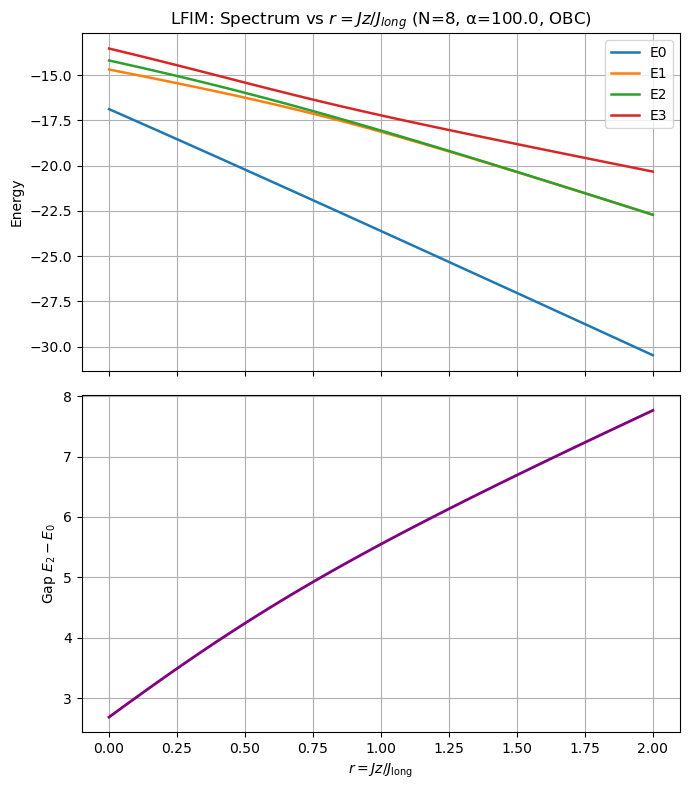

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- parameters ----------
N = 8
Jz = 0
Jlong = -1         # FM convention
alpha = 100.0      # effectively NN
periodic = False

r_vals = np.linspace(0, 2.0, 100)      # r = B/Jlong
spectra = []
gaps = []

for r in r_vals:
    Jz = r * Jlong
    H = build_hamiltonian(N, B=B, Jz=Jz, Jlong=Jlong,
                          alpha=alpha, periodic=periodic,
                          kac_rescale=False)

    evals = H.eigenenergies(eigvals=4)  # lowest 4 eigenvalues
    spectra.append(evals)
    gaps.append(evals[2] - evals[0])    # gap = E2 - E0

spectra = np.array(spectra)

# ---------- plotting ----------
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Spectrum plot (E0..E3)
for i in range(4):
    axes[0].plot(r_vals, spectra[:, i], lw=1.8, label=f"E{i}")
axes[0].set_ylabel("Energy")
axes[0].set_title(f"LFIM: Spectrum vs $r=Jz/J_{{long}}$ (N={N}, α={alpha}, {'PBC' if periodic else 'OBC'})")
axes[0].legend()
axes[0].grid(True)

# Band gap plot (E2 - E0)
axes[1].plot(r_vals, gaps, lw=2, color="purple")
axes[1].set_xlabel(r"$r = Jz/J_{\mathrm{long}}$")
axes[1].set_ylabel(r"Gap $E_2 - E_0$")
axes[1].grid(True)

plt.tight_layout()
plt.show()

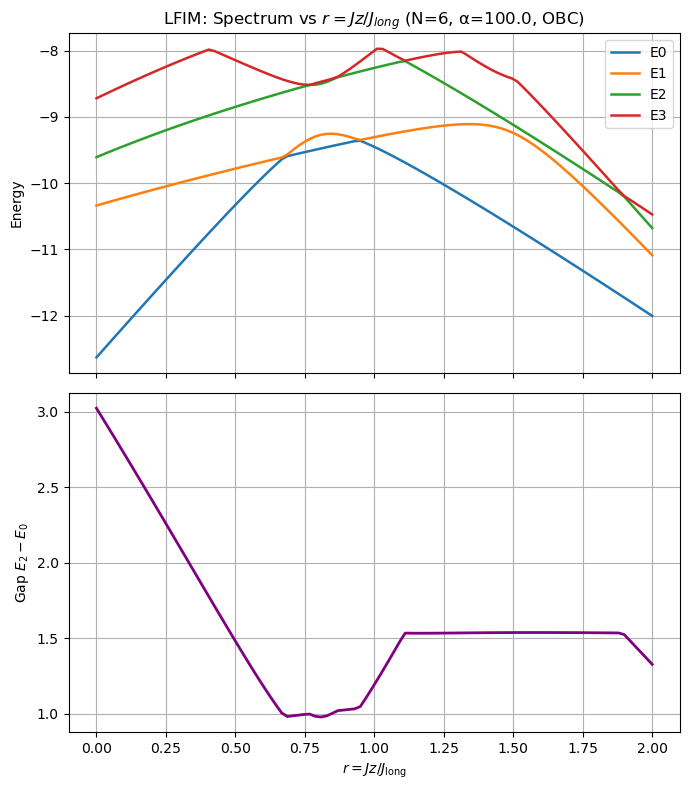

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- parameters ----------
N = 6
Jz = 0
Jlong = 1         # FM convention
alpha = 100.0      # effectively NN
periodic = False

r_vals = np.linspace(0, 2.0, 100)      # r = B/Jlong
spectra = []
gaps = []

for r in r_vals:
    Jz = r * Jlong
    H = build_hamiltonian(N, B=B, Jz=Jz, Jlong=Jlong,
                          alpha=alpha, periodic=periodic,
                          kac_rescale=False)

    evals = H.eigenenergies(eigvals=4)  # lowest 4 eigenvalues
    spectra.append(evals)
    gaps.append(evals[2] - evals[0])    # gap = E2 - E0

spectra = np.array(spectra)

# ---------- plotting ----------
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Spectrum plot (E0..E3)
for i in range(4):
    axes[0].plot(r_vals, spectra[:, i], lw=1.8, label=f"E{i}")
axes[0].set_ylabel("Energy")
axes[0].set_title(f"LFIM: Spectrum vs $r=Jz/J_{{long}}$ (N={N}, α={alpha}, {'PBC' if periodic else 'OBC'})")
axes[0].legend()
axes[0].grid(True)

# Band gap plot (E2 - E0)
axes[1].plot(r_vals, gaps, lw=2, color="purple")
axes[1].set_xlabel(r"$r = Jz/J_{\mathrm{long}}$")
axes[1].set_ylabel(r"Gap $E_2 - E_0$")
axes[1].grid(True)

plt.tight_layout()
plt.show()